In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import preprocessing


from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from numpy import mean,std
import matplotlib.pyplot as plt


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
train_features = pd.read_csv('../datasets/training_set_features.csv')
train_labels = pd.read_csv('../datasets/training_set_labels.csv')
train_data = pd.merge(train_features, train_labels, on = 'respondent_id', how='inner')

test_features = pd.read_csv('../datasets/test_set_features.csv')

In [3]:
all_dataset = pd.concat([train_data, test_features])

In [4]:
train_data.shape

(26707, 38)

In [5]:
train_data.head(2)

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1


# Encoding

In [6]:
label_encoder = preprocessing.LabelEncoder()

In [7]:
for col in ['age_group', 'education', 'race', 'sex', 
            'income_poverty', 'marital_status', 'rent_or_own', 
            'employment_status', 'hhs_geo_region', 'census_msa', 'employment_industry', 'employment_occupation']:
    all_dataset[col] = label_encoder.fit_transform(all_dataset[col].astype(str))

In [8]:
all_dataset.shape

(53415, 38)

# Handling Null Values

In [9]:
# Impute with mean & median
train_data_impute_mean = all_dataset.copy()

In [10]:
train_data_impute_mean.fillna(train_data_impute_mean.mean(), inplace=True)

In [11]:
dataset = train_data_impute_mean.copy()

In [12]:
submission_train_dataset = dataset.loc[dataset['respondent_id'] >= len(train_data)] 
submission_train_dataset = submission_train_dataset.drop(['h1n1_vaccine','seasonal_vaccine'], axis=1)
# submission_train_dataset.head()

In [13]:
dataset = dataset.loc[dataset['respondent_id'] < len(train_data)]

In [14]:
train_data['h1n1_vaccine'].value_counts()

0    21033
1     5674
Name: h1n1_vaccine, dtype: int64

# Split Train 

In [15]:
y1 = dataset['h1n1_vaccine'].astype(int)
y2 = dataset['seasonal_vaccine'].astype(int)

X = dataset.drop(['h1n1_vaccine', 'seasonal_vaccine'], axis=1)


In [16]:
# X = X.drop(['respondent_id'], axis = 1)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y1, test_size=0.15, random_state=1)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y2, test_size=0.15, random_state=1)

# Modeling

# h1n1_vaccine

In [17]:
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

# define search space
space= {   
            'max_features': hp.choice("max_features", {'auto'}),
            'n_estimators': hp.quniform('n_estimators', 200, 500, 20),
            'min_samples_leaf': hp.quniform('min_samples_leaf', 5, 10, 1)
        }


# Regression: 
def hyperparameter_tuning(space):
    model1=RandomForestClassifier( 
                                    max_features = space['max_features'], 
                                    n_estimators = int(space['n_estimators']),
                                    min_samples_leaf = int(space['min_samples_leaf'])
                                )
    
    evaluation = [( X_train1, y_train1), (X_test1, y_test1)]
    
    model1.fit(X_train1, y_train1)

    # score = model1.score(X_train1, y_train1)
    # print("Training Score: {score}".format(score=score))

    # y_pred1 = model1.predict(X_test1)


    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    roc_auc_scores = cross_val_score(model1, X_train1, y_train1, scoring='roc_auc', cv=cv, n_jobs=-1)
    mean_roc_auc = mean(roc_auc_scores)

    # roc_auc = roc_auc_score(y_test1, y_pred1)
    # print("ROC AUC : {roc_auc}".format(roc_auc=roc_auc))

    print("Mean ROC AUC: {roc_auc:.2f} -- Model: {model}".format(roc_auc = mean_roc_auc, model=model1))
    # change the metric if you like
    return {'loss': -mean_roc_auc, 'status': STATUS_OK, 'model': model1}



trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=5,
            trials=trials)

print (best)

Mean ROC AUC: 0.86 -- Model: RandomForestClassifier(min_samples_leaf=9, n_estimators=440)
Mean ROC AUC: 0.86 -- Model: RandomForestClassifier(min_samples_leaf=9, n_estimators=220)
Mean ROC AUC: 0.86 -- Model: RandomForestClassifier(min_samples_leaf=5, n_estimators=260)
Mean ROC AUC: 0.86 -- Model: RandomForestClassifier(min_samples_leaf=9, n_estimators=220)
Mean ROC AUC: 0.86 -- Model: RandomForestClassifier(min_samples_leaf=10, n_estimators=460)
100%|██████████| 5/5 [01:54<00:00, 22.85s/trial, best loss: -0.8626143427954801]
{'max_features': 0, 'min_samples_leaf': 9.0, 'n_estimators': 440.0}


In [18]:
# define model
rf_model1 = RandomForestClassifier(max_features='auto', min_samples_leaf=7, n_estimators=420)
rf_model1.fit(X_train1, y_train1)

score = rf_model1.score(X_train1, y_train1)
print("Training Score: {score:.2f}".format(score = mean(score)))
print("="*100)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
roc_auc_scores = cross_val_score(rf_model1, X_train1, y_train1, scoring='roc_auc', cv=cv, n_jobs=-1)
print("Mean ROC AUC: {score:.5f}".format(score = mean(roc_auc_scores)))
print("="*100)

y_pred1 = rf_model1.predict(X_test1)
cm = confusion_matrix(y_test1, y_pred1)
print("Confusion Matrix\n {cm}".format(cm=cm))
print("="*100)

cr = classification_report(y_test1, y_pred1)
print("Classification Report \n", cr)

Training Score: 0.89
Mean ROC AUC: 0.86259
Confusion Matrix
 [[3058  113]
 [ 442  394]]
Classification Report 
               precision    recall  f1-score   support

           0       0.87      0.96      0.92      3171
           1       0.78      0.47      0.59       836

    accuracy                           0.86      4007
   macro avg       0.83      0.72      0.75      4007
weighted avg       0.85      0.86      0.85      4007



In [19]:
train_scores, test_scores = list(), list()

last_column = len(X_train1.columns)+1

values = [i for i in range(1,last_column)]

# evaluate a decision tree for each depth
for i in values:
	# configure the model
	model = rf_model1
	# fit model on the training dataset
	model.fit(X_train1, y_train1)
	# evaluate on the train dataset
	train_yhat = model.predict(X_train1)
	train_acc = accuracy_score(y_train1, train_yhat)
	train_scores.append(train_acc)
	# evaluate on the test dataset
	test_yhat = model.predict(X_test1)
	test_acc = accuracy_score(y_test1, test_yhat)
	test_scores.append(test_acc)
	# summarize progress
	# print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

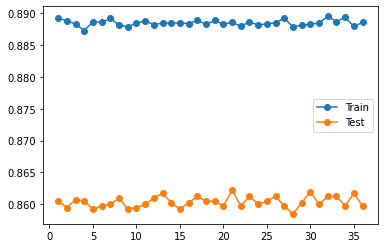

In [20]:
# plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')

plt.legend()
plt.show()

# seasonal_vaccine

In [21]:
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

# define search space
space= {   
            'max_features': hp.choice("max_features", {'auto'}),
            'n_estimators': hp.quniform('n_estimators', 200, 500, 20),
            'min_samples_leaf': hp.quniform('min_samples_leaf', 5, 10, 1)
        }


# Regression: 
def hyperparameter_tuning(space):
    model2=RandomForestClassifier( 
                                    max_features = space['max_features'], 
                                    n_estimators = int(space['n_estimators']),
                                    min_samples_leaf = int(space['min_samples_leaf'])
                                )
    
    evaluation = [( X_train2, y_train2), (X_test2, y_test2)]
    
    model2.fit(X_train2, y_train2)

    # score = model2.score(X_train2, y_train2)
    # print("Training Score: {score}".format(score=score))

    # y_pred2 = model2.predict(X_test2)


    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    roc_auc_scores = cross_val_score(model2, X_train2, y_train2, scoring='roc_auc', cv=cv, n_jobs=-1)
    mean_roc_auc = mean(roc_auc_scores)

    # roc_auc = roc_auc_score(y_test2, y_pred2)
    # print("ROC AUC : {roc_auc}".format(roc_auc=roc_auc))

    print("Mean ROC AUC: {roc_auc:.2f} -- Model: {model}".format(roc_auc = mean_roc_auc, model=model2))
    # change the metric if you like
    return {'loss': -mean_roc_auc, 'status': STATUS_OK, 'model': model2}



trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=5,
            trials=trials)

print (best)

Mean ROC AUC: 0.86 -- Model: RandomForestClassifier(min_samples_leaf=7, n_estimators=460)
Mean ROC AUC: 0.86 -- Model: RandomForestClassifier(min_samples_leaf=7, n_estimators=400)
Mean ROC AUC: 0.86 -- Model: RandomForestClassifier(min_samples_leaf=10, n_estimators=320)
Mean ROC AUC: 0.86 -- Model: RandomForestClassifier(min_samples_leaf=10, n_estimators=380)
Mean ROC AUC: 0.86 -- Model: RandomForestClassifier(min_samples_leaf=8, n_estimators=320)
100%|██████████| 5/5 [02:12<00:00, 26.53s/trial, best loss: -0.8567261601183791]
{'max_features': 0, 'min_samples_leaf': 7.0, 'n_estimators': 460.0}


In [22]:
# define model
rf_model2 = RandomForestClassifier(max_features='auto', min_samples_leaf=7, n_estimators=420)
rf_model2.fit(X_train2, y_train2)

score = rf_model2.score(X_train2, y_train2)
print("Training Score: {score:.2f}".format(score = mean(score)))
print("="*100)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
roc_auc_scores = cross_val_score(rf_model2, X_train2, y_train2, scoring='roc_auc', cv=cv, n_jobs=-1)
print("Mean ROC AUC: {score:.5f}".format(score = mean(roc_auc_scores)))
print("="*100)

y_pred2 = rf_model2.predict(X_test2)
cm = confusion_matrix(y_test2, y_pred2)
print("Confusion Matrix\n {cm}".format(cm=cm))
print("="*100)

cr = classification_report(y_test2, y_pred2)
print("Classification Report \n", cr)

Training Score: 0.86
Mean ROC AUC: 0.85663
Confusion Matrix
 [[1757  402]
 [ 461 1387]]
Classification Report 
               precision    recall  f1-score   support

           0       0.79      0.81      0.80      2159
           1       0.78      0.75      0.76      1848

    accuracy                           0.78      4007
   macro avg       0.78      0.78      0.78      4007
weighted avg       0.78      0.78      0.78      4007



In [24]:
train_scores, test_scores = list(), list()

last_column = len(X_train2.columns)+1

values = [i for i in range(1,last_column)]

# evaluate a decision tree for each depth
for i in values:
	# configure the model
	model = rf_model2
	# fit model on the training dataset
	model.fit(X_train2, y_train2)
	# evaluate on the train dataset
	train_yhat = model.predict(X_train2)
	train_acc = accuracy_score(y_train2, train_yhat)
	train_scores.append(train_acc)
	# evaluate on the test dataset
	test_yhat = model.predict(X_test2)
	test_acc = accuracy_score(y_test2, test_yhat)
	test_scores.append(test_acc)
	# summarize progress
	# print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

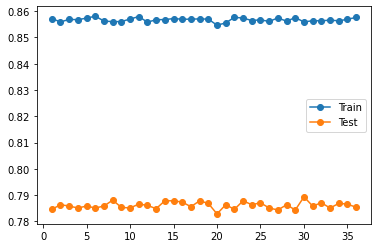

In [25]:
# plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')

plt.legend()
plt.show()

## Predictions

In [25]:
# test_features = test_features.fillna(0, inplace=True)
# test_features.head(1)

In [26]:
h1n1_vaccine_submission = rf_model1.predict(submission_train_dataset).astype(int)

seasonal_vaccine_submission = rf_model2.predict(submission_train_dataset).astype(int)

In [27]:
submission_train_dataset.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,26707,2.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.000000,5.0,1.0,1.0,5.0,1.0,1.0,1,2,1,0,1,1,1,0,7,0,1.0,0.0,1,7
1,26708,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,4.0,1.0,1.0,4.0,1.0,1.0,0,0,3,1,2,1,1,0,1,2,3.0,0.0,1,21
2,26709,2.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.883824,5.0,4.0,2.0,5.0,4.0,4.0,3,2,3,1,1,0,0,0,5,2,1.0,0.0,11,13
3,26710,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.000000,4.0,2.0,2.0,4.0,4.0,2.0,4,0,3,0,0,0,0,1,5,0,1.0,0.0,10,11
4,26711,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.000000,5.0,2.0,4.0,4.0,4.0,2.0,1,0,0,0,0,1,0,0,6,2,0.0,1.0,4,10


In [28]:
submission = pd.DataFrame({
                            "respondent_id": test_features.respondent_id,
                            "h1n1_vaccine": h1n1_vaccine_submission.astype('float64'),
                            "seasonal_vaccine": seasonal_vaccine_submission.astype('float64')
    })

In [29]:
submission.head(5)

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,26707,0.0,0.0
1,26708,0.0,0.0
2,26709,0.0,1.0
3,26710,1.0,1.0
4,26711,0.0,0.0


In [30]:
submission.to_csv('tuned_RandomForest_submission.csv', index=False)